In [10]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder \
    .appName("count") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.memory", "1024M") \
    .getOrCreate()
sc = spark.sparkContext

In [11]:
df1 = spark.read.json("hdfs://localhost:9000/datasets/spotify/playlist.json")
df1.printSchema()
df1.show(5,False)

root
 |-- collaborative: string (nullable = true)
 |-- description: string (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- name: string (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_artists: long (nullable = true)
 |-- num_edits: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- pid: long (nullable = true)

+-------------+-----------+-----------+-----------+----------------+----------+-----------+---------+-------------+----------+---+
|collaborative|description|duration_ms|modified_at|name            |num_albums|num_artists|num_edits|num_followers|num_tracks|pid|
+-------------+-----------+-----------+-----------+----------------+----------+-----------+---------+-------------+----------+---+
|false        |null       |11532414   |1493424000 |Throwbacks      |47        |37         |6        |1            |52        |0  |
|false        |null       |1

In [12]:
df2 = spark.read.json("hdfs://localhost:9000/datasets/spotify/tracks.json")
df2.printSchema()
df2.show(5,False)

root
 |-- album_name: string (nullable = true)
 |-- album_uri: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_uri: string (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- pid: long (nullable = true)
 |-- pos: long (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_uri: string (nullable = true)

+--------------------------------------------+------------------------------------+-----------------+-------------------------------------+-----------+---+---+------------------------------------------+------------------------------------+
|album_name                                  |album_uri                           |artist_name      |artist_uri                           |duration_ms|pid|pos|track_name                                |track_uri                           |
+--------------------------------------------+------------------------------------+-----------------+-------------------------------------+-----------+---+-

In [13]:
df1.createOrReplaceTempView("playlist")
df2.createOrReplaceTempView("tracks")

In [14]:

from pyspark.sql import functions as F
df_artists = spark.sql("select distinct tracks.pid,tracks.artist_name, FLOOR((playlist.modified_at/(360*24*60*60))+1970) as year from playlist,tracks where playlist.pid=tracks.pid")
df_artists.show(5)
df_artists.createOrReplaceTempView("artists") 


+---+--------------------+----+
|pid|         artist_name|year|
+---+--------------------+----+
|  1|                Seal|2018|
|  7|          Disclosure|2018|
| 11|       Pretty Lights|2013|
| 16|Unknown Mortal Or...|2017|
| 21|       Savage Garden|2017|
+---+--------------------+----+
only showing top 5 rows



In [15]:
import pandas as pd
top5 = spark.sql("select artist_name, count(*) as cnt from artists group by artist_name order by cnt desc").limit(5).toPandas()
print(top5)


      artist_name    cnt
0           Drake  32259
1         Rihanna  23963
2      Kanye West  22464
3      The Weeknd  20046
4  Kendrick Lamar  19159


In [16]:
from matplotlib import pyplot as plt


/tmp/ipykernel_202436/958660860.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


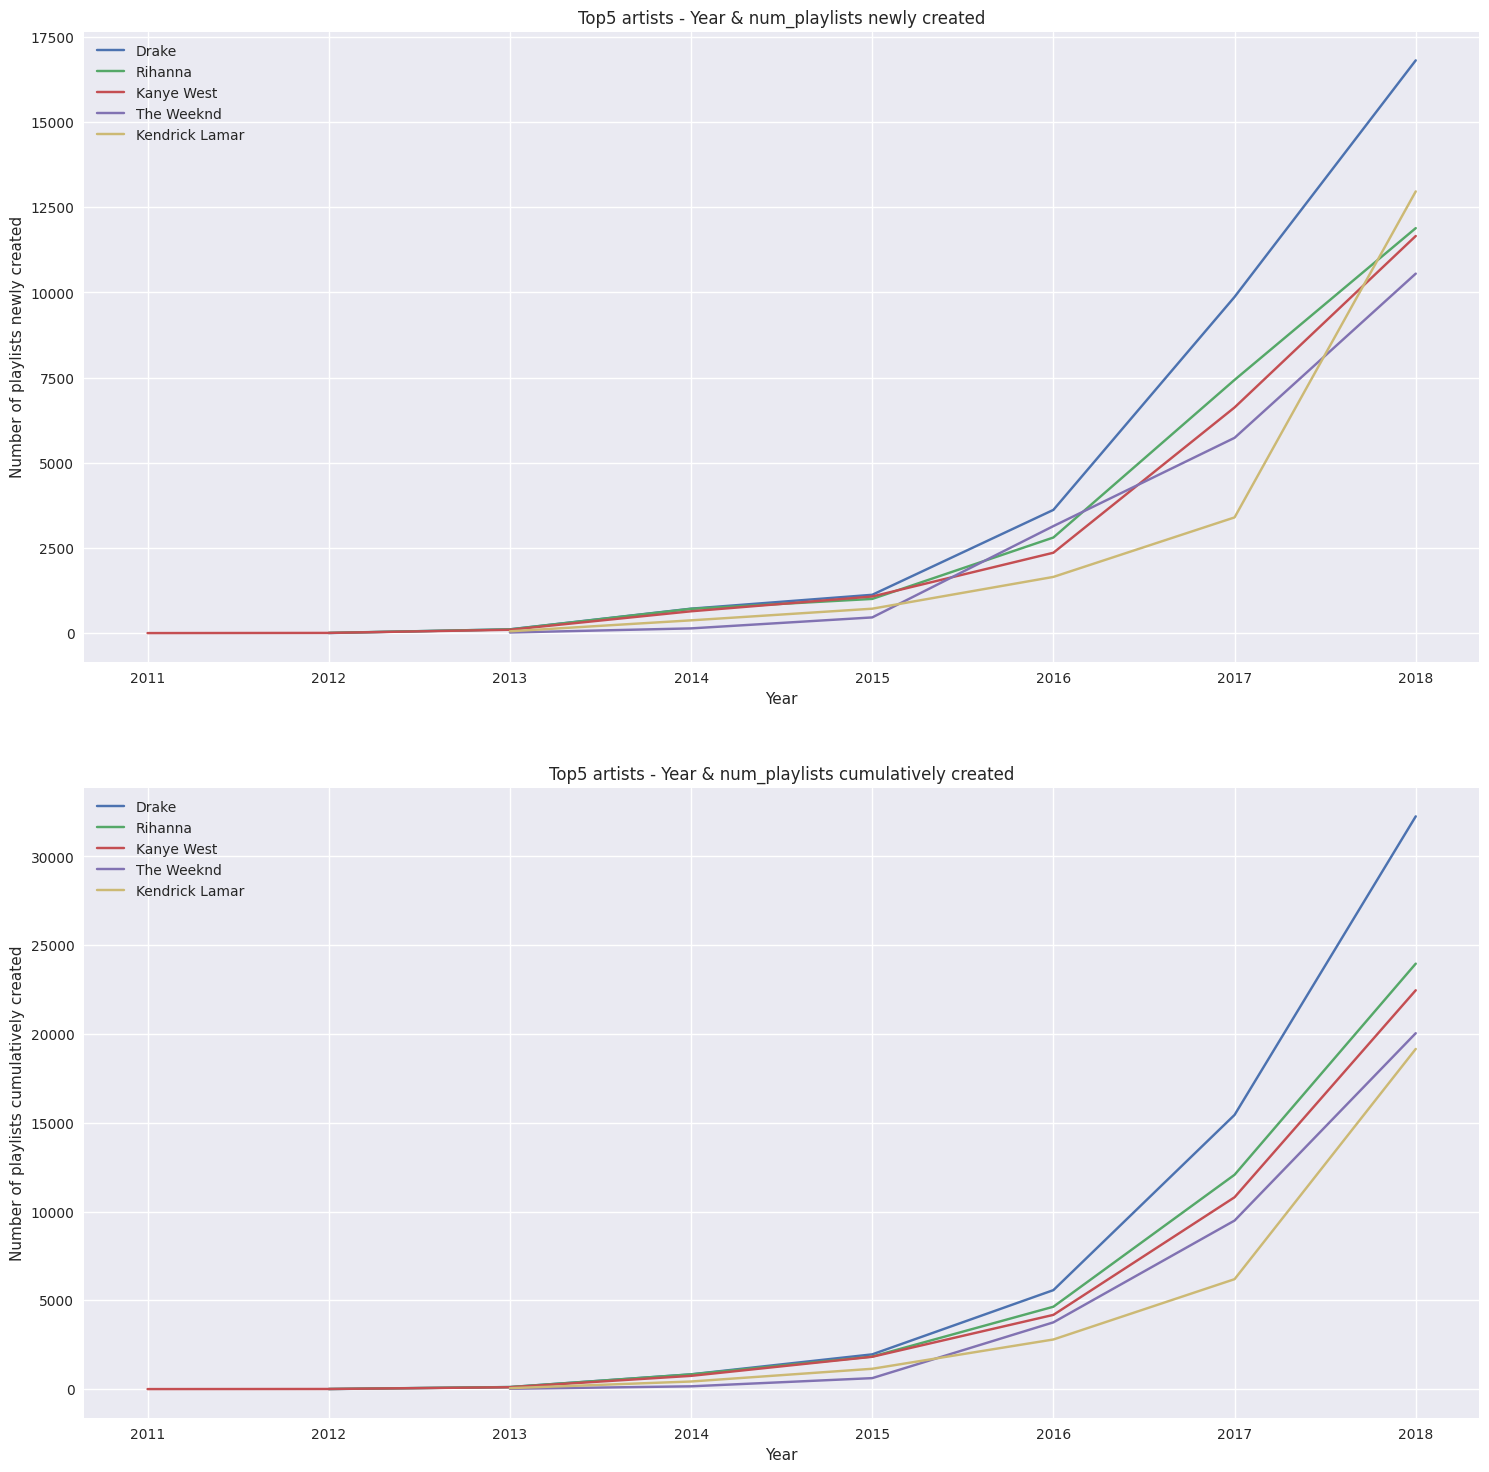

In [21]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,18))
for i in range(5):
    topi = df_artists.filter(df_artists["artist_name"] == top5['artist_name'][i]).\
        groupBy("year").\
        count().\
        orderBy("year").\
        toPandas()
    ax1.plot(topi["year"],topi["count"])
    n = len(topi["count"])
    c = [0 for i in range(n)]
    for i in range(n):
        for j in range(i+1):
            c[i] += topi["count"][j]
    ax2.plot(topi["year"],c)

ax2.set_xlabel("Year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of playlists newly created")
ax2.set_ylabel("Number of playlists cumulatively created")
ax1.set_title("Top5 artists - Year & num_playlists newly created")
ax2.set_title("Top5 artists - Year & num_playlists cumulatively created")
ax1.legend(top5["artist_name"])
ax2.legend(top5["artist_name"])